In [113]:
import pandas as pd
import numpy as np
import sys
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
from plotly import express as px
import scipy as sp



from st_utils import correct_tissue_names, correct_platform_panel,name_parser
from constants import SAMPLES, sample_color
from constants import matching_cores_2024 as matching_cores

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

    
wd = os.getcwd()
print (f'working directory: {wd}')

year = '2024'
if year == '2024':
    samples = [x for x in SAMPLES if '2024' in x]
elif year == '2023':
    samples = [x for x in SAMPLES if '2024' not in x]
else:
    samples = [x for x in SAMPLES]
print (samples)
    

working directory: /mnt/disks/store/ist_benchmarking
['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']


In [114]:
supplement=True

# Functions to load data and calculate specificity , sensitivity

In [115]:

def load(sample): # Load gene level data and tag with core metadata
    # Core information: including tissue_type, tumor ...
    csv_sample_info = f"{wd}/data/Sample_Info_{name_parser(sample)['tma'].upper()}_TMA - Sheet1.csv"
    df_core = pd.read_csv(csv_sample_info)[['core','tissue_type']]
    df_core = correct_tissue_names(sample,df_core)
    df_core['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)

    # Rachel curated gene list
    gene_list = pd.read_csv(f"{wd}/data/gene_lists/{name_parser(sample)['platform']}_{name_parser(sample)['panel']}.csv").columns.to_list()

    # Core x gene
    df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
    df_t = correct_tissue_names(sample,df_t)
    df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)

    return df_t, df_core, gene_list

def specificity(sample, df_t, df_core):
    """Fraction of calls on target"""

    df_g = df_t.groupby(['core','tissue_type','code_type']).sum().reset_index()
    valid_tissues = sorted(df_t.tissue_type.unique())

    if 'Marker' in valid_tissues:
        valid_tissues.remove('Marker')
    if 'MARKER' in valid_tissues:
        valid_tissues.remove('MARKER')

    df_mat = df_g.pivot_table(index='core',columns='code_type',values='count', aggfunc='sum')
    df_mat = df_mat.fillna(0)
    df_mat['specificity'] = df_mat['gene']/df_mat.sum(axis=1)
    df_mat = pd.merge(df_core, df_mat, on='core', how='inner')

    # Save data
    df_mat.to_csv(f'{wd}/data/specificity/{sample}_specificity.csv', index=False)

def sensitivity(sample, df_t, df_core, matching_cores):
    """Number of gene reliably detected above noise (2 STD above average negative control expression)"""

    df_pos_genes = pd.DataFrame()
    neg_metric = 'blank' if 'merscope' in sample else 'neg_control_probe'
    genes = df_t.loc[df_t['code_type']=='gene']['gene'].unique()
    n_genes = df_t.loc[df_t['code_type']=='gene']['gene'].nunique()
    negative_controls = df_t.loc[df_t['code_type']==neg_metric]['gene'].unique()
    df_t = df_t.loc[df_t['core'].isin(matching_cores)]

    df2_mat = df_t.pivot(index='gene',columns='core',values='count').fillna(0)
    mean_neg_probes = df2_mat.loc[negative_controls].mean()
    sd_neg_probes = df2_mat.loc[negative_controls].std()

    i = 2 # Number of STD

    df_pos_genes[f'mean+{i}std'] = np.sum(df2_mat.loc[genes] > (mean_neg_probes + i * sd_neg_probes))
    # normalize by number of genes
    df_pos_genes[f'mean+{i}std_%'] = df_pos_genes[f'mean+{i}std'] * 100 / n_genes

    df_pos_genes = pd.merge(df_pos_genes, df_core, on='core', how='inner')
    df_pos_genes_mean = df_pos_genes.groupby('tissue_type').mean()
    df_pos_genes_mean.to_csv(f'{wd}/data/gene_above_noise/{sample}_gene_above_noise.csv')

    return n_genes


# Calculate specificity, sensitivity for multiple data sets

In [116]:
if not os.path.exists(f'{wd}/data/specificity'):
    os.makedirs(f'{wd}/data/specificity')

if not os.path.exists(f'{wd}/data/gene_above_noise'):
    os.makedirs(f'{wd}/data/gene_above_noise')


sample_genes = {}

df_cores_htma = pd.read_csv(f'{wd}/data/core_availability_htma.csv')
df_cores_normal = pd.read_csv(f'{wd}/data/core_availability_normal.csv')
df_cores_tumor2 = pd.read_csv(f'{wd}/data/core_availability_tumor2.csv')

df_cores_both = pd.DataFrame()
df_cores_both = pd.concat([df_cores_both, df_cores_htma]) 
df_cores_both = pd.concat([df_cores_both, df_cores_normal])
df_cores_both = pd.concat([df_cores_both, df_cores_tumor2])

df_matching_cores = {}
matching_cores = []

for tma in ['htma', 'normal','tumor2']:
    df = df_cores_both.copy()
    for s in samples:
        df = df.loc[df[s] == 1.0] if tma in s else df
    df_matching_cores[tma] = df
    print (df['core'].nunique(), f'cores in all {tma} tma samples')

matching_cores = list(df_matching_cores['normal']['core'].unique())+list(df_matching_cores['htma']['core'].unique())+list(df_matching_cores['tumor2']['core'].unique())
matching_cores = sorted(matching_cores)

df_t_all = {}


tma = 'both'  # both, tumor, normal

if tma == 'both':
    run_samples = samples
elif tma == 'tumor':
    run_samples = [x for x in samples if tma in x]
elif tma == 'normal':
    run_samples = [x for x in samples if tma in x]
elif tma == 'tumor2':
    run_samples = [x for x in samples if tma in x]
else:
    print ('error')



for sample in run_samples:
    print (f'sample: {sample}')
    df_t, df_core, gene_list = load(sample)
    df_t_all[sample] = df_t
    specificity(sample, df_t, df_core)
    n_genes = sensitivity(sample, df_t, df_core, matching_cores)
    sample_genes[f"{name_parser(sample)['platform'].upper()}_{name_parser(sample)['panel'].capitalize()}"] = n_genes
display(sample_genes)


86 cores in all htma tma samples
272 cores in all normal tma samples
41 cores in all tumor2 tma samples
sample: 2024_xenium_breast_htma
sample: 2024_xenium_breast_tumor2
sample: 2024_merscope_breast_htma
sample: 2024_merscope_breast_tumor2
sample: 2024_cosmx_multitissue_htma
sample: 2024_cosmx_multitissue_tumor2


{'XENIUM_Breast': 480, 'MERSCOPE_Breast': 255, 'COSMX_Multitissue': 1000}

In [117]:
metric = 'specificity'
df_m = pd.DataFrame()
for sample in run_samples:
    print (f'sample: {sample}')
    df_metric = pd.read_csv(f'{wd}/data/specificity/{sample}_specificity.csv')
    df_metric['sample'] = sample
    df_m = pd.concat([df_m,df_metric])
    df_m = df_m[['core','tissue_type','sample','specificity']]
df_m = df_m.loc[df_m['core'].isin(matching_cores)]


sample: 2024_xenium_breast_htma
sample: 2024_xenium_breast_tumor2
sample: 2024_merscope_breast_htma
sample: 2024_merscope_breast_tumor2
sample: 2024_cosmx_multitissue_htma
sample: 2024_cosmx_multitissue_tumor2


# Review specificity

In [118]:
metric = 'specificity'
df_m = pd.DataFrame()
for sample in run_samples:
    print (f'sample: {sample}')
    df_metric = pd.read_csv(f'{wd}/data/specificity/{sample}_specificity.csv')
    df_metric['sample'] = sample
    df_m = pd.concat([df_m,df_metric])
    df_m = df_m[['core','tissue_type','sample','specificity']]
df_m = df_m.loc[df_m['core'].isin(matching_cores)]

df_m['Platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'].capitalize())
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)['tma'].upper())


###
### By Platform * panel
###

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel']).agg({'specificity': 'mean'}).reset_index()
df_plot['Platform_Panel'] = df_plot.apply(lambda row: f"{row['Platform']}_{row['panel']}", axis=1)
df_plot = correct_platform_panel(df_plot, 'Platform_Panel')
df_plot['specificity'] = df_plot['specificity'] * 100
df_plot['specificity'] = df_plot['specificity'].apply(lambda x: round(x,2))
# display(df_plot[['Platform_Panel','specificity']].groupby(['Platform_Panel']).mean().round(1))
df_p_p = df_plot.copy()


###
### By Platform
###

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform']).agg({'specificity': 'mean'}).reset_index()
df_plot['specificity'] = df_plot['specificity'] * 100
df_plot['specificity'] = df_plot['specificity'].apply(lambda x: round(x,2))

df_plot_spe = df_plot.copy()
df_plot_spe = df_plot_spe.rename(columns={metric:'value'})
df_plot_spe['metric'] = '% calls on genes'
df_plot_spe = df_plot_spe.groupby(['tissue_type','Platform','metric']).agg({'value': 'mean'}).reset_index()

if supplement:
    df_plot_spe = df_p_p.copy()
    df_plot_spe = df_plot_spe.rename(columns={metric:'value'})
    df_plot_spe['metric'] = '% calls on genes'
    df_plot_spe = df_plot_spe.groupby(['tissue_type','Platform_Panel','metric']).agg({'value': 'mean'}).reset_index()
    
display(df_plot_spe.head(5))

sample: 2024_xenium_breast_htma
sample: 2024_xenium_breast_tumor2
sample: 2024_merscope_breast_htma
sample: 2024_merscope_breast_tumor2
sample: 2024_cosmx_multitissue_htma
sample: 2024_cosmx_multitissue_tumor2


,tissue_type,Platform_Panel,metric,value
0,BlC,"CosMx,1k",% calls on genes,97.97
1,BlC,"MERSCOPE,breast",% calls on genes,96.14
2,BlC,"Xenium,breast",% calls on genes,99.89
3,BrC,"CosMx,1k",% calls on genes,97.30
4,BrC,"MERSCOPE,breast",% calls on genes,98.42


# Review sensitivity by total number
In the absence of paired RNA-seq data for each individual sample, we quantified sensitivity by measuring the number
of genes detected above noise. For each core, we calculated the number of genes detected one, two, and three
standard deviations above the average of the 20 negative control probes. These numbers were then averaged for
cores of the same tissue type. As expected, the number of genes detected decreased with increasing stringency. All
genes were detected at least once in each TMA.

In [119]:
i = 2
metric = f'mean+{i}std'
df_m = pd.DataFrame()
for sample in run_samples:
    print (f'sample: {sample}')
    df_metric = pd.read_csv(f'{wd}/data/gene_above_noise/{sample}_gene_above_noise.csv')
    df_metric['sample'] = sample
    df_m = pd.concat([df_m,df_metric])
    
df_m['Platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'].capitalize())
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)['tma'].upper())

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel']).agg({metric: 'mean'}).reset_index()
df_plot['Platform_Panel'] = df_plot.apply(lambda row: f"{row['Platform']}_{row['panel']}", axis=1)
df_plot = correct_platform_panel(df_plot, 'Platform_Panel')
df_p_p = df_plot.copy()

### By Platform
df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel']).agg({metric: 'mean'}).reset_index()

df_plot_sen = df_plot.copy()
df_plot_sen = df_plot_sen.rename(columns={metric:'value'})
df_plot_sen['metric'] = 'genes above noise'
df_plot_sen = df_plot_sen.drop('panel', axis=1)
df_plot_sen = df_plot_sen.groupby(['tissue_type','Platform','metric']).agg({'value': 'mean'}).reset_index()

if supplement:
    df_plot_sen = df_p_p.copy()
    df_plot_sen = df_plot_sen.rename(columns={metric:'value'})
    df_plot_sen['metric'] = 'genes above noise'
    df_plot_sen = df_plot_sen.drop('panel', axis=1)
    df_plot_sen = df_plot_sen.groupby(['tissue_type','Platform_Panel','metric']).agg({'value': 'mean'}).reset_index()

df_plot_sen.head()

sample: 2024_xenium_breast_htma
sample: 2024_xenium_breast_tumor2
sample: 2024_merscope_breast_htma
sample: 2024_merscope_breast_tumor2
sample: 2024_cosmx_multitissue_htma
sample: 2024_cosmx_multitissue_tumor2


,tissue_type,Platform_Panel,metric,value
0,BlC,"CosMx,1k",genes above noise,546.833333
1,BlC,"MERSCOPE,breast",genes above noise,61.000000
2,BlC,"Xenium,breast",genes above noise,252.196078
3,BrC,"CosMx,1k",genes above noise,548.058824
4,BrC,"MERSCOPE,breast",genes above noise,127.750000


# Review sensitivity by %

In [120]:
i = 2
metric = f'mean+{i}std_%'
df_m = pd.DataFrame()
for sample in run_samples:
    print (f'sample: {sample}')
    df_metric = pd.read_csv(f'{wd}/data/gene_above_noise/{sample}_gene_above_noise.csv')
    df_metric['sample'] = sample
    df_m = pd.concat([df_m,df_metric])
    
df_m['Platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'].capitalize())
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)['tma'].upper())

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel']).agg({metric: 'mean'}).reset_index()
df_plot['Platform_Panel'] = df_plot.apply(lambda row: f"{row['Platform']}_{row['panel']}", axis=1)
df_plot = correct_platform_panel(df_plot, 'Platform_Panel')
df_p_p = df_plot.copy()

### By Platform
df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel']).agg({metric: 'mean'}).reset_index()

df_plot_sen_pa = df_plot.copy()
df_plot_sen_pa = df_plot_sen_pa.rename(columns={metric:'value'})
df_plot_sen_pa['metric'] = '% genes above noise'
df_plot_sen_pa = df_plot_sen_pa.drop('panel', axis=1)
df_plot_sen_pa = df_plot_sen_pa.groupby(['tissue_type','Platform','metric']).agg({'value': 'mean'}).reset_index()

if supplement:
    df_plot_sen_pa = df_p_p.copy()
    df_plot_sen_pa = df_plot_sen_pa.rename(columns={metric:'value'})
    df_plot_sen_pa['metric'] = '% genes above noise'
    df_plot_sen_pa = df_plot_sen_pa.drop('panel', axis=1)
    df_plot_sen_pa = df_plot_sen_pa.groupby(['tissue_type','Platform_Panel','metric']).agg({'value': 'mean'}).reset_index()

df_plot_sen_pa.head()

sample: 2024_xenium_breast_htma
sample: 2024_xenium_breast_tumor2
sample: 2024_merscope_breast_htma
sample: 2024_merscope_breast_tumor2
sample: 2024_cosmx_multitissue_htma
sample: 2024_cosmx_multitissue_tumor2


,tissue_type,Platform_Panel,metric,value
0,BlC,"CosMx,1k",% genes above noise,54.683333
1,BlC,"MERSCOPE,breast",% genes above noise,23.921569
2,BlC,"Xenium,breast",% genes above noise,52.540850
3,BrC,"CosMx,1k",% genes above noise,54.805882
4,BrC,"MERSCOPE,breast",% genes above noise,50.098039


In [123]:
if not os.path.exists('tables'):
    os.makedirs('tables')

if supplement:

    total_gene_dict = {
        'Xenium,breast':280,
        'Xenium,multi-tissue':377,
        'Xenium,lung':289,
        'MERSCOPE,breast':255,
        'MERSCOPE,lung':220,
        'CosMx,1k':1000,
    }

    df_p_p['total_gene'] = df_p_p['Platform_Panel'].apply(lambda x: total_gene_dict[x])
    df_p_p['sensed_gene'] = df_p_p.apply(lambda row: int(row['mean+2std_%'] * row['total_gene'] * 0.01), axis=1)

    metric = 'Sensed Genes'
    original_metric = 'mean+2std_%'  # sensed_gene
    df = df_p_p[['tissue_type','Platform_Panel',original_metric]] 
    df = df.rename(columns = {'tissue_type':'Tissue Type', original_metric:'Sensed Genes'})

    pivoted_df = df.pivot_table(index='Tissue Type', columns='Platform_Panel', values=metric)
    pivoted_df.reset_index(inplace=False)

    pivoted_df.to_csv(f'{wd}/tables/sensed_genes.csv')


# Function to apply styling to the maximum value in each column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: limegreen; text-align: center' if v else 'background-color: white; text-align: center' for v in is_max]

# Apply the style with highlighted maximum values and centered text
styled_df = pivoted_df.style.apply(highlight_max, axis=1)

# Display the styled DataFrame
styled_df

Platform_Panel,"CosMx,1k","MERSCOPE,breast","Xenium,breast"
Tissue Type,,,
BlC,54.683333,23.921569,52.540850
BrC,54.805882,50.098039,55.078125
Breast invasive,33.600000,30.196078,56.979167
Breast non-invasive DCIS_2,46.750000,18.627451,58.125000
Breast non-invasive DCIS_3,41.600000,26.078431,55.000000
CRC,60.817391,52.119514,54.563708
HNSCC,54.479167,34.357298,52.862319
Kidney cancer,46.750000,53.529412,56.250000
Liposarcoma,11.500000,nan,nan


In [124]:
## FDR negative
df_fdr1_orignal = pd.read_csv(f'{wd}/data/fdr/negative_{year}.csv')
df_fdr1_orignal = df_fdr1_orignal.loc[df_fdr1_orignal['sample'].isin(run_samples)]
if tma == 'tumor':
    df_fdr1_orignal = df_fdr1_orignal.loc[df_fdr1_orignal['sample'].str.contains('htma')]
elif tma == 'normal':
    df_fdr1_orignal = df_fdr1_orignal.loc[df_fdr1_orignal['sample'].str.contains('normal')]
elif tma == 'tumo2':
    df_fdr1_orignal = df_fdr1_orignal.loc[df_fdr1_orignal['sample'].str.contains('tumor2')]
else:
    df_fdr1_orignal = df_fdr1_orignal.copy()

df_fdr1 = df_fdr1_orignal.drop(['sample','panel'], axis=1)
df_fdr1 = df_fdr1.rename(columns={'fdr':'value', 'modality':'Platform'})
df_fdr1['metric'] = 'Log₁₀FDR(negative)'
df_fdr1 = df_fdr1.groupby(['tissue_type','Platform','metric']).agg({'value': 'mean'}).reset_index()
df_fdr1['value'] = df_fdr1['value'].replace(0, 0.0001)
df_fdr1['value'] = np.log10(df_fdr1['value'])

if supplement:
    df_fdr1 = df_fdr1_orignal.rename(columns={'fdr':'value'})
    df_fdr1['metric'] = 'Log₁₀FDR(negative)'
    df_fdr1 = df_fdr1.groupby(['tissue_type','Platform_Panel','metric']).agg({'value': 'mean'}).reset_index()
    df_fdr1['value'] = df_fdr1['value'].replace(0, 0.0001)
    df_fdr1['value'] = np.log10(df_fdr1['value'])


# FDR blank
df_fdr2_original = pd.read_csv(f'{wd}/data/fdr/blank_{year}.csv')
df_fdr2_original = df_fdr2_original.loc[df_fdr2_original['sample'].isin(run_samples)]
if tma == 'tumor':
    df_fdr2_original = df_fdr2_original.loc[df_fdr2_original['sample'].str.contains('htma')]
elif tma == 'normal':
    df_fdr2_original = df_fdr2_original.loc[df_fdr2_original['sample'].str.contains('normal')]
elif tma == 'tumo2':
    df_fdr2_original = df_fdr2_original.loc[df_fdr2_original['sample'].str.contains('tumor2')]
else:
    df_fdr2_original = df_fdr2_original.copy()

df_fdr2 = df_fdr2_original.drop(['sample','panel'], axis=1)
df_fdr2 = df_fdr2.rename(columns={'fdr':'value', 'modality':'Platform'})
df_fdr2['metric'] = 'Log₁₀FDR(blank)'
df_fdr2 = df_fdr2.groupby(['tissue_type','Platform','metric']).agg({'value': 'mean'}).reset_index()
df_fdr2['value'] = df_fdr2['value'].replace(0, 0.0001)
df_fdr2['value'] = np.log10(df_fdr2['value'])

if supplement:
    df_fdr2 = df_fdr2_original.rename(columns={'fdr':'value'})
    df_fdr2['metric'] = 'Log₁₀FDR(blank)'
    df_fdr2 = df_fdr2.groupby(['tissue_type','Platform_Panel','metric']).agg({'value': 'mean'}).reset_index()
    df_fdr2['value'] = df_fdr2['value'].replace(0, 0.0001)
    df_fdr2['value'] = np.log10(df_fdr2['value'])

# Combine all
df_plot = pd.DataFrame()
df_plot = pd.concat([df_plot_sen, df_plot_sen_pa])
df_plot = pd.concat([df_plot, df_plot_spe])
df_plot = pd.concat([df_plot, df_fdr1])
df_plot = pd.concat([df_plot, df_fdr2])
df_plot = df_plot.loc[~df_plot['tissue_type'].isin(['Pancreas','Renal pelvis','BlC'])]
df_plot.head()

,tissue_type,Platform_Panel,metric,value
3,BrC,"CosMx,1k",genes above noise,548.058824
4,BrC,"MERSCOPE,breast",genes above noise,127.750000
5,BrC,"Xenium,breast",genes above noise,264.375000
6,Breast invasive,"CosMx,1k",genes above noise,336.000000
7,Breast invasive,"MERSCOPE,breast",genes above noise,77.000000


In [143]:
if not os.path.exists(f'{wd}/figures/Fig_2_Technical_Performance'):
    os.makedirs(f'{wd}/figures/Fig_2_Technical_Performance')


if year == '2023':
    custom_ticks = ['BrC','CRC','HNSCC','Mel', 'NSCLC', 'OvC','Bladder',  
                    'Breast',  'Colon',  'Heart','Kidney', 'Liver',
                    'Lung', 'Lymph node', 'Ovary', 'Prostate',
                    'Skin', 'Spleen', 'Thyroid', 'Tonsil']

elif year == "2024":
    custom_ticks = ['BrC', 'CRC', 'HNSCC','Mel', 'NSCLC', 'OvC','Breast invasive', 
                    'Breast non-invasive DCIS_2','Breast non-invasive DCIS_3',  
                    'Kidney cancer','Liver cancer', 
                    'Lymph node', 'Lymphoma Hodgkin','Lymphoma LN B cell', 'Lymphoma non-Hodgkin',
                    'Pancreas cancer', 'Prostate cancer', 'Renal cancer', 'SCC',
                    'Testes cancer', 'Thyroid cancer', 'Tonsil']
df_plotly = df_plot.copy()
df_plotly = df_plotly.loc[df_plot['tissue_type'].isin(custom_ticks)]

fontsize=15
width = 1000
if supplement:
    width=1200
height = 1100
groupby = 'Platform'
if supplement:
    groupby = 'Platform_Panel'
    custom_palette = {}
    for Platform_Panel in df_plotly['Platform_Panel'].unique():
        custom_palette[Platform_Panel] = sample_color[Platform_Panel]

# Define your initial figure
fig = px.bar(df_plotly, x="tissue_type", y="value",
             color=groupby, barmode="group", 
             facet_row="metric", color_discrete_map=custom_palette,
             width=width, height=height,
             category_orders={"metric": ['% calls on genes',
                                         'Log₁₀FDR(blank)',
                                         'Log₁₀FDR(negative)',
                                         'genes above noise',
                                         '% genes above noise']})


print ('FDR was log10 transformed to show the difference, hard to see xenium when cosmx FDR is around 100.')

# Update x-axis settings with black text
fig.update_xaxes(tickvals=df_plotly['tissue_type'].unique(),
                 ticktext=custom_ticks, tickangle=270, title_text='', 
                 title_font=dict(color='black'), tickfont=dict(color='black', size=fontsize))


# Update y-axis settings with black text
fig.update_yaxes(matches=None, title_text='', title_font=dict(color='black'), tickfont=dict(color='black', size=fontsize-2))
fig.update_yaxes(row=1, range=[0, 102], title_font=dict(color='black'), tickfont=dict(color='black'))
fig.update_yaxes(row=2, range=[0, 700], title_font=dict(color='black'), tickfont=dict(color='black'))
fig.update_yaxes(row=3, range=[-1, 2], title_font=dict(color='black'), tickfont=dict(color='black'))
fig.update_yaxes(row=4, range=[-1, 2], title_font=dict(color='black'), tickfont=dict(color='black'))
fig.update_yaxes(row=5, range=[90,102], title_font=dict(color='black'), tickfont=dict(color='black'))

fig.update_xaxes(row=1, showline=True, linewidth=2, linecolor='black')
fig.update_xaxes(row=2, showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(row=3, zeroline=True, zerolinewidth=2, zerolinecolor='black')
fig.update_yaxes(row=4, zeroline=True, zerolinewidth=2, zerolinecolor='black')
fig.update_xaxes(row=5, showline=True, linewidth=2, linecolor='black')

fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

# Update legend settings
fig.update_layout(
    legend=dict(
        orientation="h",  # horizontal alignment
        yanchor="bottom", 
        y=1,  # position legend just above the plot
        xanchor="right",
        x=0.99  # center the legend
    ),
    font=dict(color='black'),  # Set global font color to black
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    
)

# Modify row title annotations and set text color to black
for annotation in fig.layout.annotations:
    annotation.font.size = fontsize
    annotation.font.color = 'black'  # Set the annotation text color to black
    annotation.x = -0.06
    annotation.textangle = 270
    for metric in df_plot.metric.unique():
        if annotation.text == f'metric={metric}':
            annotation.text = metric

# Display the figure and save to file
fig.show()
if supplement:
    pio.write_image(fig, f'{wd}/figures/Fig_2_Technical_Performance/Supp_Fig_2_tech_{year}_{tma}_tma.png',scale=4, width=width, height=height)
else:
    pio.write_image(fig, f'{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_tech_{year}_{tma}_tma.png',scale=4, width=width, height=height)



FDR was log10 transformed to show the difference, hard to see xenium when cosmx FDR is around 100.


# Panel to panel reproducibity

In [61]:
samples = [sample for sample in SAMPLES[:12]]

for sample in samples:
    print (f'sample: {sample}')
    df_t, df_core, gene_list = load(sample)
    df_t_all[sample] = df_t

df_all = {}

Platform_Panels =  ['Xenium,breast',
                    'Xenium,multi-tissue',
                    'Xenium,lung',
                    'MERSCOPE,breast',
                    'MERSCOPE,lung',
                    'CosMx,1k']

for i in range(0,6):
    df_all[Platform_Panels[i]] = pd.DataFrame()
    df_htma = df_t_all[samples[2*i]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_htma])
    df_normal = df_t_all[samples[2*i+1]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_normal])

sample: xenium_breast_htma
sample: xenium_breast_normal
sample: xenium_panhuman_htma
sample: xenium_panhuman_normal
sample: xenium_lung_htma
sample: xenium_lung_normal
sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_lung_htma
sample: merscope_lung_normal
sample: cosmx_multitissue_htma
sample: cosmx_multitissue_normal


Xenium,breast vs. Xenium,multi-tissue


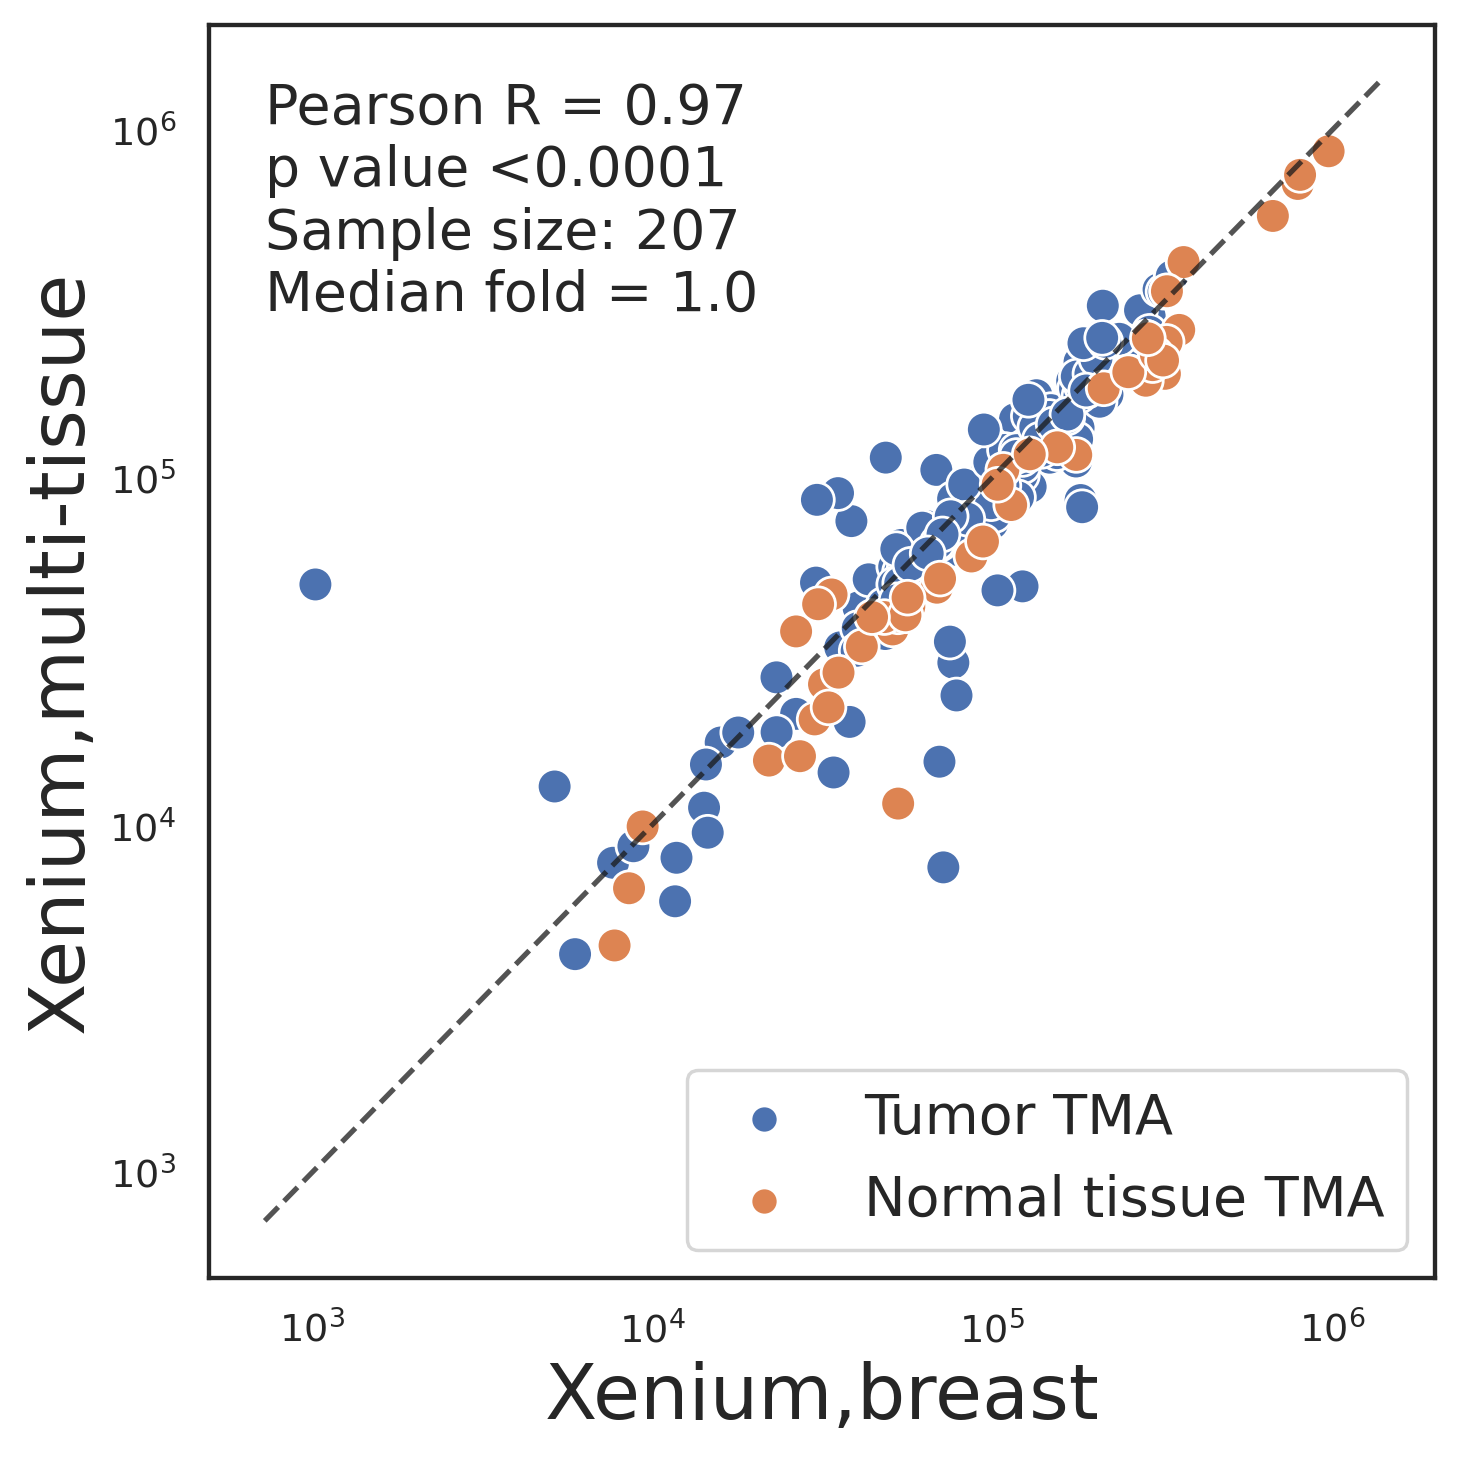

Xenium,breast vs. Xenium,lung


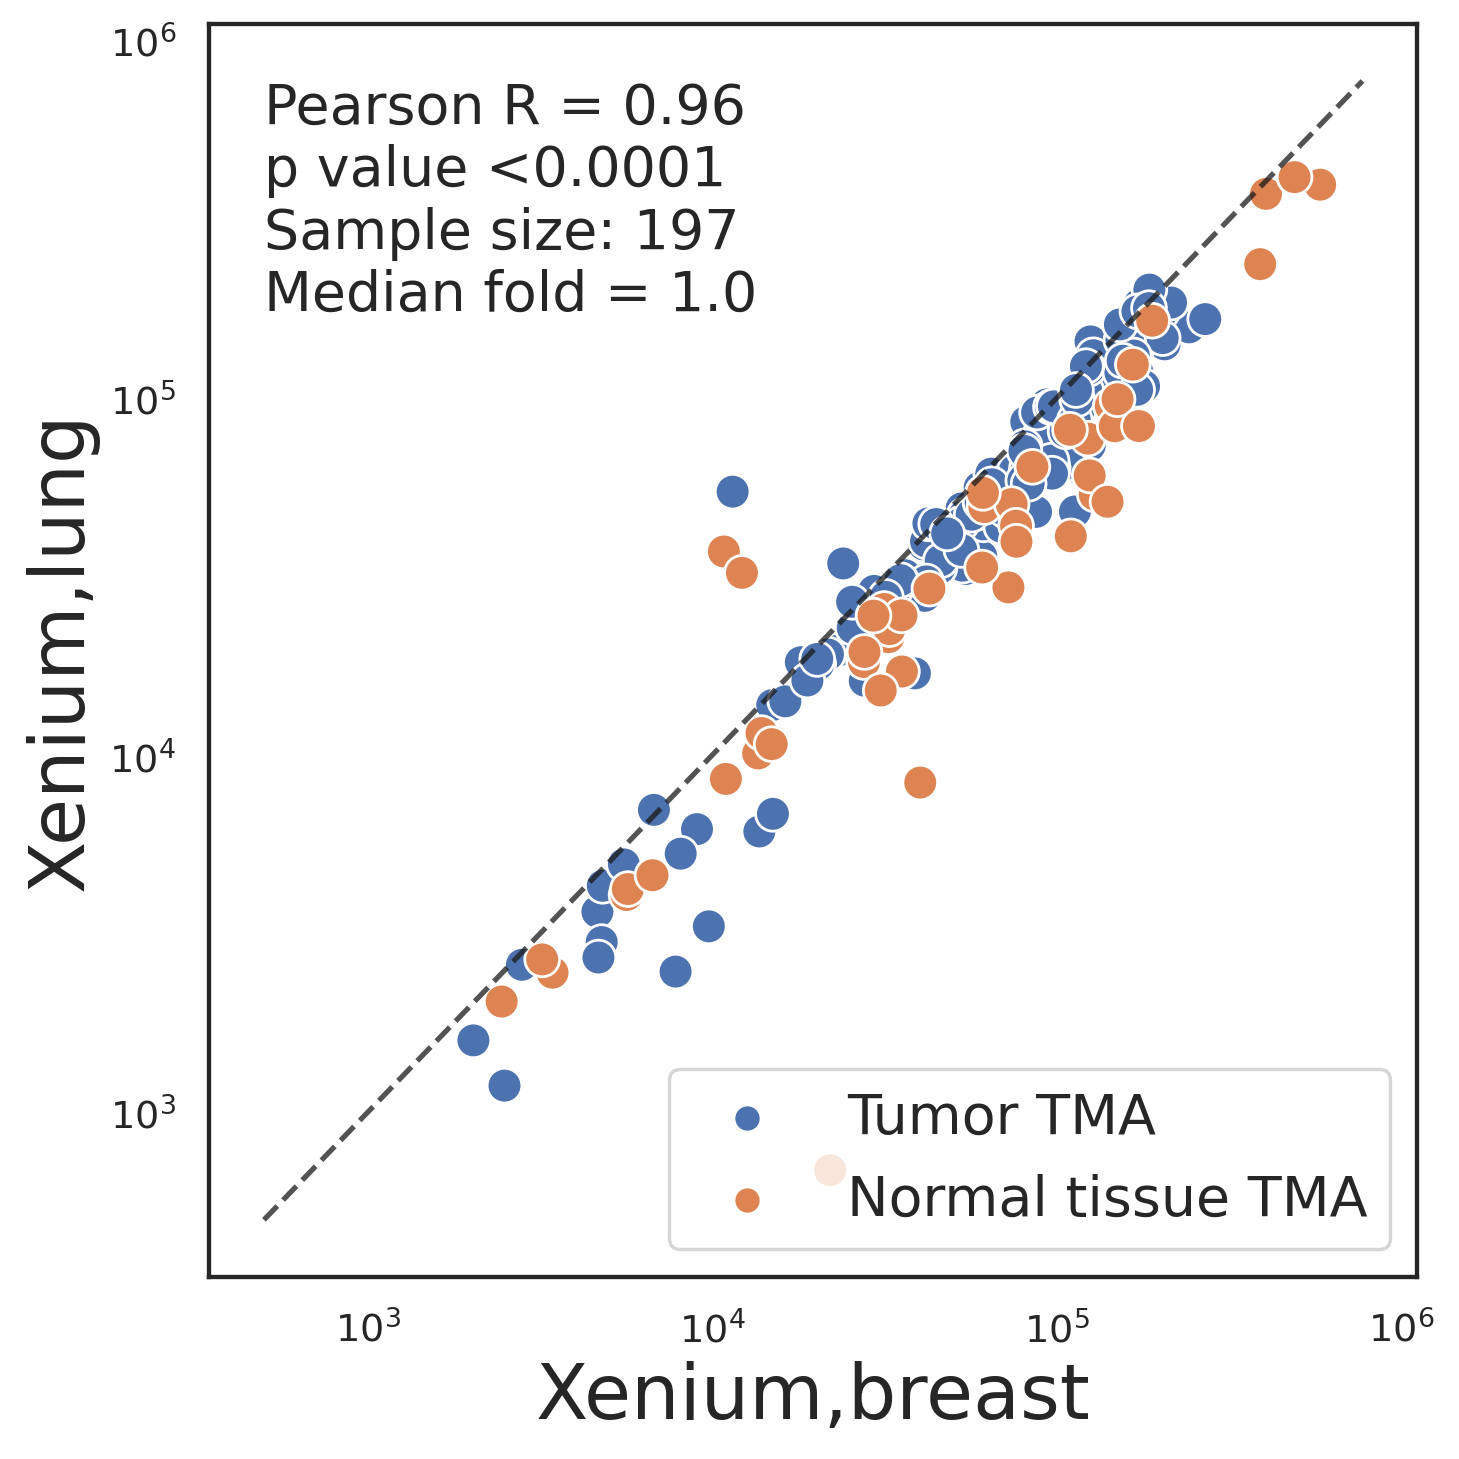

MERSCOPE,breast vs. MERSCOPE,lung


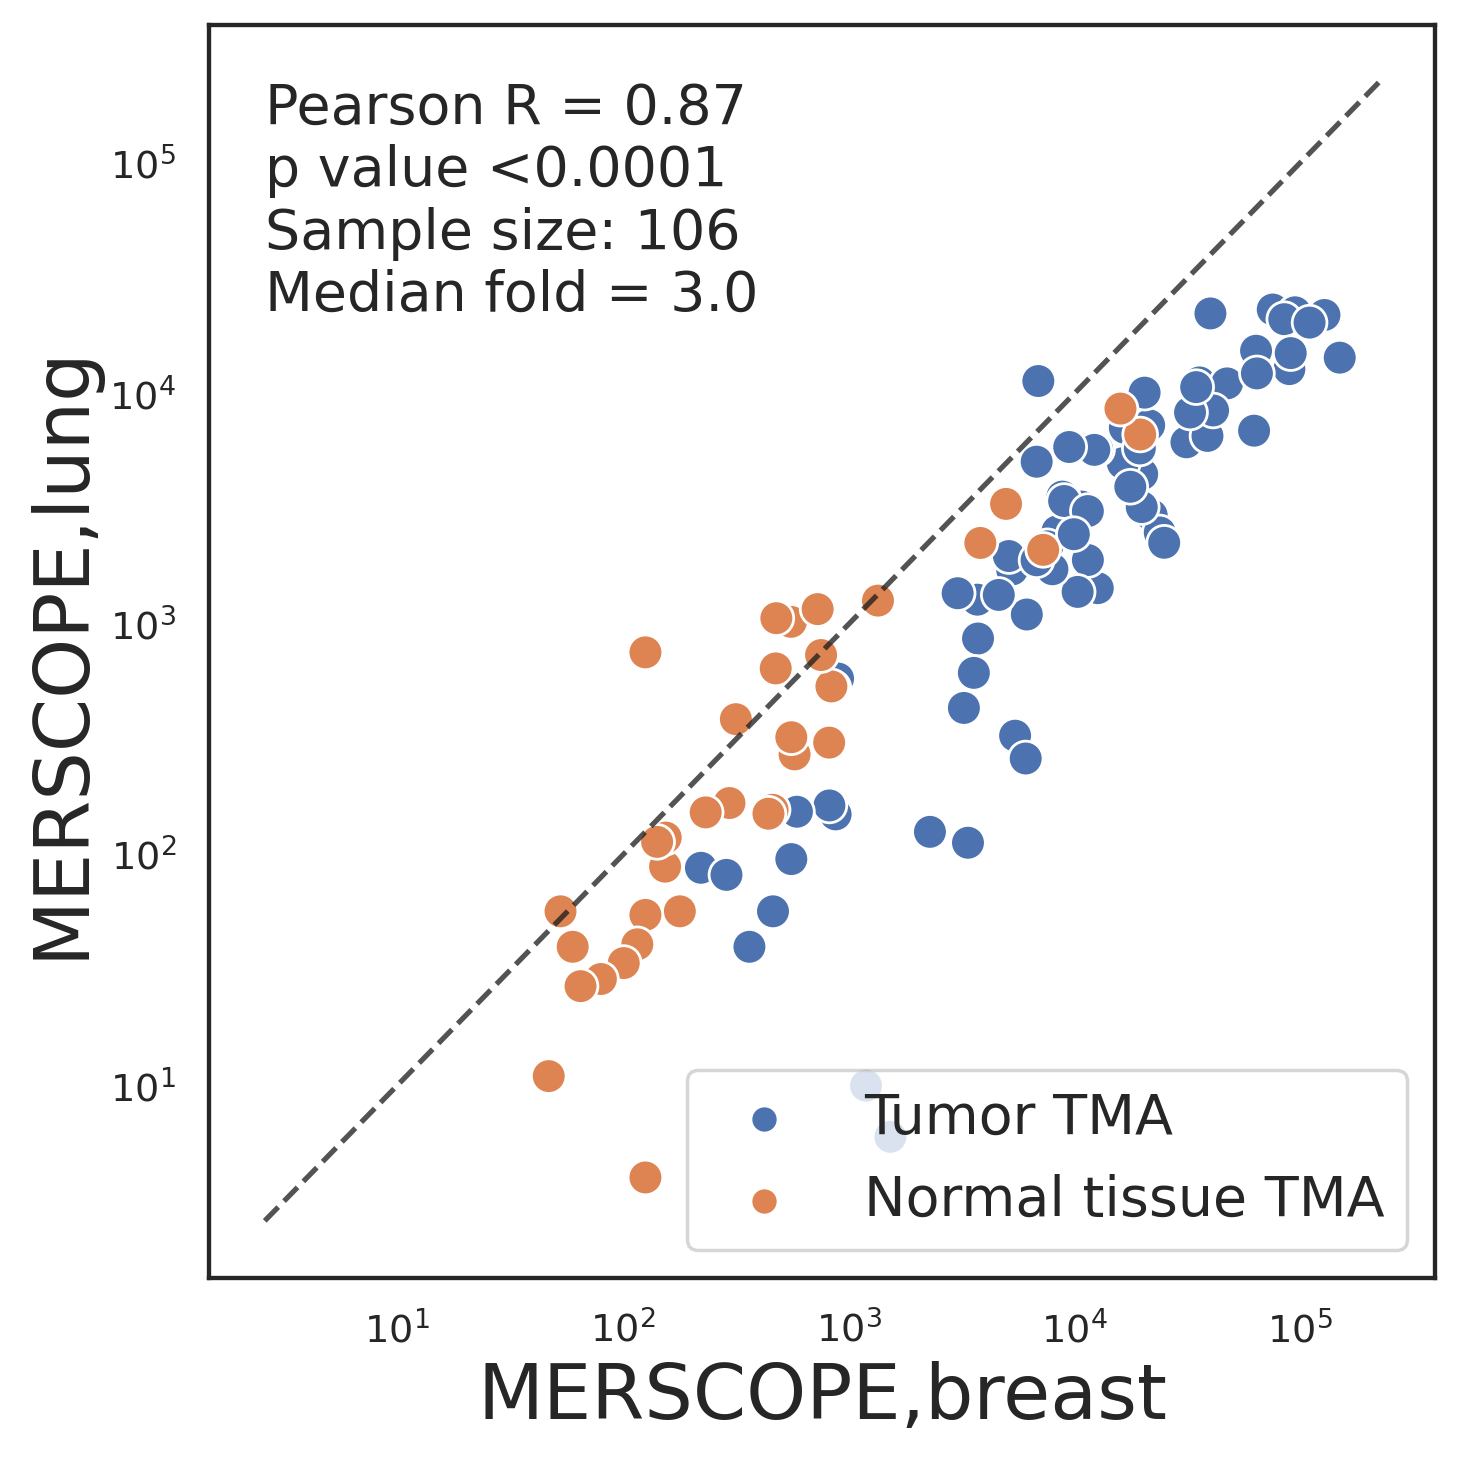

In [62]:
if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')


for Platform_Panel_pair in [(Platform_Panels[0],Platform_Panels[1]), # panel to panel, xenium
                    (Platform_Panels[0],Platform_Panels[2]),# panel to panel, xenium
                    (Platform_Panels[3],Platform_Panels[4])]:# panel to panel, merscope

    sample1 = Platform_Panel_pair[0]    
    df_1 = df_all[sample1].rename(columns={'count':sample1})
    df_1 = df_1.loc[df_1['code_type']=='gene'].drop('code_type', axis=1)

    sample2 = Platform_Panel_pair[1]
    df_2 = df_all[sample2].rename(columns={'count':sample2})
    df_2 = df_2.loc[df_2['code_type']=='gene'].drop('code_type', axis=1)

    print (f'{sample1} vs. {sample2}')

    common_genes = np.intersect1d(df_1.gene.unique(),df_2.gene.unique())
    df_1 = df_1.loc[df_1['gene'].isin(common_genes)]
    df_1 = df_1.groupby(['core', 'tissue_type']).agg({sample1:'sum'}).reset_index()
    df_2 = df_2.loc[df_2['gene'].isin(common_genes)]
    df_2 = df_2.groupby(['core', 'tissue_type']).agg({sample2:'sum'}).reset_index()

    df_both = pd.merge(df_1, df_2, on=['core', 'tissue_type'], how='inner')
    df_both['Core source'] = df_both['core'].apply(lambda x: 'Tumor TMA' if int(x) < 200 else 'Normal tissue TMA')
    df_both['fold'] = df_both.apply(lambda row: round(row[sample1] /row[sample2]), axis=1)
    sns.set(style='white',
            rc={'figure.figsize': (6, 6),
                'figure.dpi': 250})

    ax = sns.scatterplot(data=df_both, x=f"{sample1}", y=f"{sample2}", hue='Core source', alpha=1, s=100)

    # Increase the font size of axis labels and add some padding
    plt.xlabel(f"{sample1}", fontsize=22, labelpad=3)
    plt.ylabel(f"{sample2}", fontsize=22, labelpad=3)

    r, p = sp.stats.pearsonr(x=df_both[f"{sample1}"], y=df_both[f"{sample2}"])
    p = '<0.0001' if p < 0.0001 else round(p, 7)

    plt.xscale('log')
    plt.yscale('log')

    # 1:1 dashed line
    lims1 = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
    lims2 = [np.max([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
    plt.plot(lims1, lims1, 'k--', alpha=0.75)
    fontsize = 16
    plt.text(lims1[0], lims1[1], 
             f"Pearson R = {round(r,2)}\np value {p}\nSample size: {len(df_both)}\nMedian fold = {round(df_both['fold'].median(), 1)}", 
             fontsize=fontsize, verticalalignment='top')
    plt.legend(loc='lower right', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f'{wd}/figures/Fig_1/supp_1_reproducibity_{sample1}_vs_{sample2}.png', bbox_inches='tight')

    plt.show()


# MERSCOPE: Round 1 breast vs. round 2 breast 

In [64]:
# df_t_all = {}

# samples = ['merscope_breast_htma',
#             'merscope_breast_normal',
#             'merscope_breast_htma_round1',
#             'merscope_breast_normal_round1',
#             'merscope_lung_htma',
#             'merscope_lung_normal']

# for sample in samples:
#     print (f'sample: {sample}')
#     df_t, df_core, gene_list = load(sample)
#     df_t_all[sample] = df_t

# df_all = {}

# Platform_Panels =  ['MERSCOPE,breast(round2-10µm)',
#                     'MERSCOPE,breast(round1-5µm)',
#                     'MERSCOPE,lung',
#                     ]

# for i in range(0,3):
#     df_all[Platform_Panels[i]] = pd.DataFrame()
#     df_htma = df_t_all[samples[2*i]].copy()
#     df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_htma])
#     df_normal = df_t_all[samples[2*i+1]].copy()
#     df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_normal])


# for Platform_Panel_pair in [(Platform_Panels[0],Platform_Panels[1]),
#                             (Platform_Panels[1],Platform_Panels[2])]:

#     sample1 = Platform_Panel_pair[0]    
#     df_1 = df_all[sample1].rename(columns={'count':sample1})
#     df_1 = df_1.loc[df_1['code_type']=='gene'].drop('code_type', axis=1)

#     sample2 = Platform_Panel_pair[1]
#     df_2 = df_all[sample2].rename(columns={'count':sample2})
#     df_2 = df_2.loc[df_2['code_type']=='gene'].drop('code_type', axis=1)

#     print (f'{sample1} vs. {sample2}')

#     common_genes = np.intersect1d(df_1.gene.unique(),df_2.gene.unique())
#     df_1 = df_1.loc[df_1['gene'].isin(common_genes)]
#     df_1 = df_1.groupby(['core', 'tissue_type']).agg({sample1:'sum'}).reset_index()
#     df_2 = df_2.loc[df_2['gene'].isin(common_genes)]
#     df_2 = df_2.groupby(['core', 'tissue_type']).agg({sample2:'sum'}).reset_index()

#     df_both = pd.merge(df_1, df_2, on=['core', 'tissue_type'], how='inner')
#     df_both['Core source'] = df_both['core'].apply(lambda x: 'Tumor TMA' if int(x) < 200 else 'Normal tissue TMA')
#     df_both['fold'] = df_both.apply(lambda row: round(row[sample1] /row[sample2]), axis=1)
#     sns.set(style='white',
#             rc={'figure.figsize': (6, 6),
#                 'figure.dpi': 250})

#     ax = sns.scatterplot(data=df_both, x=f"{sample1}", y=f"{sample2}", hue='Core source', alpha=1, s=100)

#     # Increase the font size of axis labels and add some padding
#     plt.xlabel(f"{sample1}", fontsize=22, labelpad=3)
#     plt.ylabel(f"{sample2}", fontsize=22, labelpad=3)

#     r, p = sp.stats.pearsonr(x=df_both[f"{sample1}"], y=df_both[f"{sample2}"])
#     p = '<0.0001' if p < 0.0001 else round(p, 7)

#     plt.xscale('log')
#     plt.yscale('log')

#     # 1:1 dashed line
#     lims1 = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
#     lims2 = [np.max([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
#     plt.plot(lims1, lims1, 'k--', alpha=0.75)
#     fontsize = 16
#     plt.text(lims1[0], lims1[1], 
#              f"Pearson R = {round(r,2)}\np value {p}\nSample size: {len(df_both)}\nMedian fold = {round(df_both['fold'].median(), 1)}", 
#              fontsize=fontsize, verticalalignment='top')
#     plt.legend(loc='lower right', fontsize=fontsize)
#     plt.tight_layout()
#     plt.savefig(f'{wd}/figures/Fig_1/supp_1_reproducibity_{sample1}_vs_{sample2}.png', bbox_inches='tight')
#     plt.show()